In [21]:
import cdsapi
import netCDF4
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [22]:
#Retrieve data with the CDS API and store as a netCDF4 file in the working directory.
# CMIP6 climate projections (https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview)

c = cdsapi.Client()

c.retrieve(
    'projections-cmip6',
    {
        'format': 'zip',
        'date': '2022-04-10/2022-05-15',
        'temporal_resolution': 'daily',
        'experiment': 'ssp1_1_9',
        'level': 'single_levels',
        'variable': 'daily_maximum_near_surface_air_temperature',
        'model': 'ec_earth3',
        'area': [
            2, 38, 1,
            39,
        ],
    },
    'download.zip')

2022-05-02 18:00:29,641 INFO Welcome to the CDS
2022-05-02 18:00:29,644 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2022-05-02 18:00:29,878 INFO Request is queued
2022-05-02 18:00:30,952 INFO Request is running
2022-05-02 18:00:38,332 INFO Request is completed
2022-05-02 18:00:38,334 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data2/adaptor.esgf_wps.retrieve-1651510833.4624848-8482-12-6ee7c215-1157-40ae-8fe2-b2999c1ecf31.zip to download.zip (184.7K)
2022-05-02 18:00:38,963 INFO Download rate 295K/s                                                                      


Result(content_length=189170,content_type=application/zip,location=https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data2/adaptor.esgf_wps.retrieve-1651510833.4624848-8482-12-6ee7c215-1157-40ae-8fe2-b2999c1ecf31.zip)

In [23]:
# Open netCDF4 file
f = netCDF4.Dataset('C:/Users/marsu/Downloads/tasmax_day_EC-Earth3_ssp119_r4i1p1f1_gr_20220410-20220515_v20200425.nc')
 
# Extract variable
temp = f.variables['tasmax']
 
# Get dimensions: time, latitude, longitude
time_dim, lat_dim, lon_dim = temp.get_dims()
time_var = f.variables[time_dim.name]
times = num2date(time_var[:], time_var.units)
latitudes = f.variables[lat_dim.name][:]
longitudes = f.variables[lon_dim.name][:]
 
output_dir = 'E:/María/GIS_DataManag_courses/Geospatial/DegreeDays_data/'

In [25]:
#Write data as a csv table with 4 columns: time, latitude, longitude, temperature

filename = os.path.join(output_dir, 'table.csv')
print(f'Writing data in tabular form to {filename}')
      
times_grid, latitudes_grid, longitudes_grid = [
    x.flatten() for x in np.meshgrid(times, latitudes, longitudes, indexing='ij')]
df = pd.DataFrame({
    'time': [t.isoformat() for t in times_grid],
    'latitude': latitudes_grid,
    'longitude': longitudes_grid,
    'temperature': temp[:].flatten()})  #to convert N dimensional array to 1D
df.to_csv(filename, index=False)

print('Done')

Writing data in tabular form to E:/María/GIS_DataManag_courses/Geospatial/DegreeDays_data/table.csv
Done


In [37]:
df = pd.read_csv('E:/María/GIS_DataManag_courses/Geospatial/DegreeDays_data/table.csv')

max_t = 35.5
min_t = 12.7
temperature_C = []
DegreeDays = []
DegreeDays_ac = []
total = 0

#Convert Kelvin units to Celsius
for i in df.temperature:
    temp_C = int(i - 273)
    temperature_C.append(temp_C)

#Calculate DegreeDays
for i in temperature_C:
    if i < min_t:
        DD = 0
    elif min_t < i < max_t:
        DD = i - min_t
    elif i > max_t:
        DD = max_t - min_t
    DegreeDays.append(DD)

#Calculate DegreeDays accumulated
for i in DegreeDays:
    total = total + i
    DegreeDays_ac.append(total)
    
#Adding new columns to csv
df['temperature_C'] = temperature_C
df['DegreeDays'] = DegreeDays
df['DegreeDays_ac'] = DegreeDays_ac
df.to_csv('E:/María/GIS_DataManag_courses/Geospatial/DegreeDays_data/table.csv', index= False)
data = pd.DataFrame(df)
data

,time,latitude,longitude,temperature,temperature_C,DegreeDays,DegreeDays_ac
0,2022-04-10T12:00:00,1.052630,38.671875,311.56802,38,22.8,22.8
1,2022-04-10T12:00:00,1.754383,38.671875,311.90005,38,22.8,45.6
2,2022-04-11T12:00:00,1.052630,38.671875,311.13495,38,22.8,68.4
3,2022-04-11T12:00:00,1.754383,38.671875,311.61150,38,22.8,91.2
4,2022-04-12T12:00:00,1.052630,38.671875,309.19160,36,22.8,114.0
...,...,...,...,...,...,...,...
67,2022-05-13T12:00:00,1.754383,38.671875,310.44614,37,22.8,1547.9
68,2022-05-14T12:00:00,1.052630,38.671875,311.06810,38,22.8,1570.7
69,2022-05-14T12:00:00,1.754383,38.671875,311.03296,38,22.8,1593.5
70,2022-05-15T12:00:00,1.052630,38.671875,310.90027,37,22.8,1616.3


In [12]:
#Identify DegreeDay at 150ºC and 550ºC

for i in df.DegreeDays_ac:
    if i <= 150:
        final1 = int(i)
    if i <= 550:
        final2 = int(i)
    
print(final1, final2)


136 547


2022-04-28 10:03:26,813 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-04-28 10:03:26,818 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


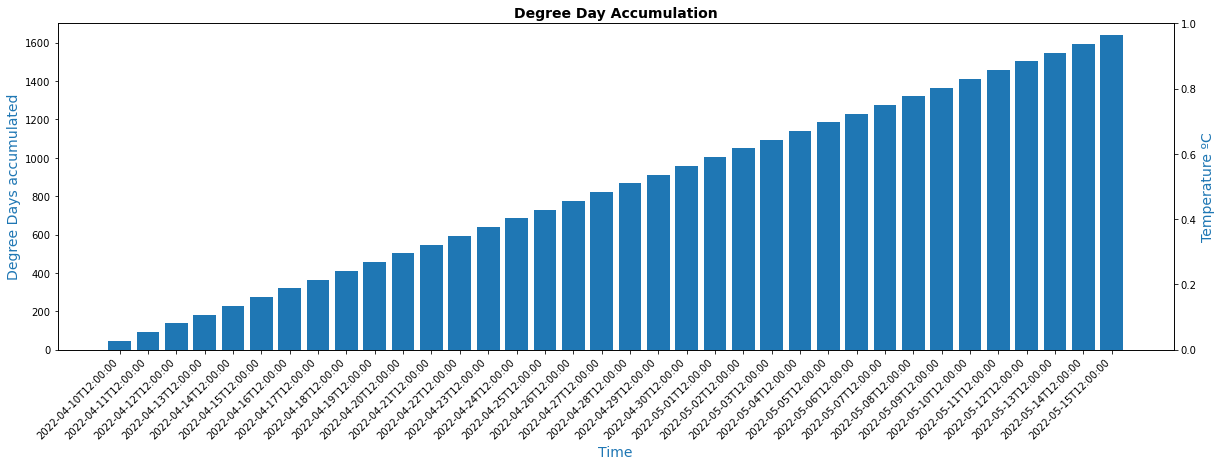

In [17]:
# Create plot to represent Degree Days
fig, ax = plt.subplots()
plt.bar(df['time'],df['DegreeDays_ac'])
plt.rcParams["figure.figsize"] = (20,6)

# Set up axis: 'x' and 'y'
plt.title('Degree Day Accumulation', loc = "center", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
plt.xlabel("Time",fontdict = {'fontsize':14, 'color':'tab:blue'})
plt.ylabel("Degree Days accumulated", fontdict = {'fontsize':14, 'color':'tab:blue'})
plt.xticks(rotation = 45, ha='right', fontsize= 10)
plt.ylim([0,1700])

# Adding a second x-axis ('Temperature ºC')
ax2 = ax.twinx()
#x2 = plt.plot(df['temperature_C'], color='red',label='Temperature')
#plt.ylim([10, 35])
plt.ylabel("Temperature ºC", fontdict = {'fontsize':14, 'color':'tab:blue'})
#plt.yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

plt.show()

In [ ]:
Things to sort out:
#Add visual map to locate area of interest
#reduce num of decimals
#simplify code (functions)
#Complete DegreeDay Accumulation Plot
#Indicate dates on which DegreeDays occur.